# LSTM Sentiment Analysis

> **Note**: This notebook is compatible with both Google Colab and local Jupyter environments. Colab-specific sections are clearly marked.

In this notebook, we build and evaluate two deep learning models for binary sentiment classification on Amazon product reviews:

- **Base Model**: A standard LSTM classifier using the final hidden state.
- **Attention Model**: An LSTM enhanced with an attention mechanism to weight and aggregate important tokens dynamically.

The workflow includes:
- Vocabulary construction and padding
- Custom PyTorch datasets and batching with masking
- Training with early stopping and metric tracking
- Evaluation using accuracy, precision, recall, specificity, F1, AUROC, and AUPRC

We compare both models side by side to assess the impact of adding attention in capturing sentiment from noisy, real-world text data.

This is part of my week 4 exporation of **Deep Learning for NLP**.

In [ ]:
!pip install swifter torchtext

In [2]:
import sys
import os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

    project_path = '/content/drive/MyDrive/NLP_Projects/Week_4/dl-sequence-models'
    if os.path.exists(project_path):
        os.chdir(project_path)
        print(f"Changed working directory to: {project_path}")
    else:
        raise FileNotFoundError(f"Project path not found: {project_path}")
else:
    print("Not running in Colab — skipping Drive mount.")

Mounted at /content/drive
Changed working directory to: /content/drive/MyDrive/NLP_Projects/Week_4/dl-sequence-models


## Load Libraries

In [31]:
# load required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import swifter

from collections import Counter

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, ConfusionMatrixDisplay, confusion_matrix

## Load and Clean Data

This section loads the preprocessed Amazon reviews dataset split into training, validation, and test sets. This is the same dataset that we used in Week 1 for traditional ML sentiment classification. We perform the following cleaning steps:

- **Removes empty or null reviews** from each dataset.
- **Filters out very short reviews** (≤ 10 characters), which are unlikely to provide meaningful sentiment signals.

These steps help ensure the models are trained and evaluated on meaningful and complete text samples.

In [4]:
X_train = pd.read_csv('../../data/amazon_sentiment/X_train_nltk.csv')
X_val = pd.read_csv('../../data/amazon_sentiment/X_val_nltk.csv')
X_test = pd.read_csv('../../data/amazon_sentiment/X_test_nltk.csv')

y_train = pd.read_csv('../../data/amazon_sentiment/y_train.csv').squeeze()
y_val = pd.read_csv('../../data/amazon_sentiment/y_val.csv').squeeze()
y_test = pd.read_csv('../../data/amazon_sentiment/y_test.csv').squeeze()

In [5]:
inds = X_train['review'].isna()
X_train = X_train[~inds]
y_train = y_train[~inds]

inds = X_val['review'].isna()
X_val = X_val[~inds]
y_val = y_val[~inds]

inds = X_test['review'].isna()
X_test = X_test[~inds]
y_test = y_test[~inds]

In [6]:
inds = X_train['review'].swifter.apply(len).values > 10
X_train = X_train[inds]
y_train = y_train[inds]

inds = X_val['review'].swifter.apply(len).values > 10
X_val = X_val[inds]
y_val = y_val[inds]

inds = X_test['review'].swifter.apply(len).values > 10
X_test = X_test[inds]
y_test = y_test[inds]

Pandas Apply:   0%|          | 0/559998 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/140000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/400000 [00:00<?, ?it/s]

## Tokenize Reviews

The cleaned reviews are tokenized by simply splitting each review string on whitespace. This results in a list of tokens (words) for each review in the training, validation, and test sets. These tokenized inputs will be used to train and evaluate classical NLP models.

In [7]:
X_train_tokens = X_train['review'].swifter.apply(lambda x: x.split()).tolist()
X_val_tokens = X_val['review'].swifter.apply(lambda x: x.split()).tolist()
X_test_tokens = X_test['review'].swifter.apply(lambda x: x.split()).tolist()

Pandas Apply:   0%|          | 0/559997 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/139998 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/399999 [00:00<?, ?it/s]

## Vocabulary Construction

This section focuses on building the vocabulary from the tokenized training data. The vocabulary will be used to map words to integer indices for input to machine learning models.

In [8]:
counter = Counter()
for text in X_train_tokens:
  counter.update(text)

### Token Frequency Distribution

We compute basic statistics on token occurrences, including the total number of tokens, vocabulary size, and descriptive statistics (mean, median, min, max, and standard deviation).  
A histogram is then plotted to visualize the distribution of token frequencies, focusing on tokens that appear fewer than 4,000 times to highlight the long-tailed nature of the distribution.

In [9]:
counts = np.array(list(counter.values()))

print('Total Number of Tokens:', counts.sum())
print('Vocab Size:', len(counts))
print('Average Occurrence of Tokens:', counts.mean())
print('Median Occurrence of Tokens:', np.median(counts))
print('Max Occurrence:', counts.max())
print('Min Occurrence:', counts.min())
print('Occurrence Std:', counts.std())

Total Number of Tokens: 21178397
Vocab Size: 568595
Average Occurrence of Tokens: 37.24689277957069
Median Occurrence of Tokens: 1.0
Max Occurrence: 559651
Min Occurrence: 1
Occurrence Std: 1206.9640111243364


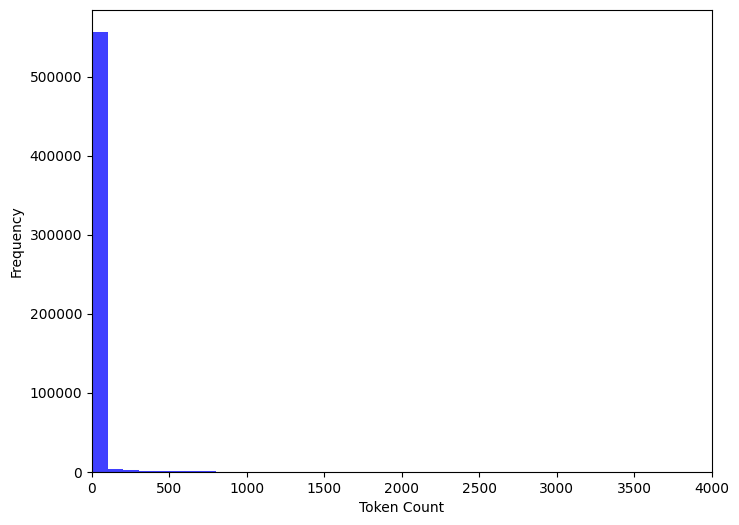

In [10]:
counts = np.array(list(counter.values()))

plt.figure(figsize = (8, 6))
sns.histplot(counts, binwidth = 100, edgecolor = 'black', color = 'blue')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.xlim(0, 4000)
plt.show()

### Vocabulary Filtering and Token Index Mapping

After examining the overall token frequency distribution, we apply a cutoff to filter out infrequent tokens—specifically those that appear fewer than 5 times in the training data. This threshold helps reduce noise from rare or misspelled tokens and results in a more compact and robust vocabulary.

We then re-calculate summary statistics (e.g., mean, median, standard deviation) on the filtered vocabulary to assess how token frequency is distributed among the remaining words. The top 10 most frequent tokens are also displayed to give a qualitative sense of the vocabulary composition.

To prepare the vocabulary for model training, we construct a final token list starting with two special tokens:
- `<PAD>` for padding sequences to equal lengths
- `<UNK>` to handle out-of-vocabulary words

The remaining tokens from the filtered vocabulary are added in descending order of frequency. Finally, we create:
- `stoi` (string-to-index) mapping: for converting words to numerical IDs
- `itos` (index-to-string) mapping: for decoding numerical predictions back to tokens

In [11]:
vocab_filtered = {k:v for k, v in counter.items() if v >= 5}

In [12]:
counts_filtered = np.array(list(vocab_filtered.values()))

print('Total Number of Tokens:', counts_filtered.sum())
print('Vocab Size:', len(counts_filtered))
print('Average Occurrence of Tokens:', counts_filtered.mean())
print('Median Occurrence of Tokens:', np.median(counts_filtered))
print('Max Occurrence:', counts_filtered.max())
print('Min Occurrence:', counts_filtered.min())
print('Occurrence Std:', counts_filtered.std())

Total Number of Tokens: 20534163
Vocab Size: 74502
Average Occurrence of Tokens: 275.61894982685027
Median Occurrence of Tokens: 14.0
Max Occurrence: 559651
Min Occurrence: 5
Occurrence Std: 3324.534991972998


In [13]:
vocab_filtered_lst = sorted(vocab_filtered.items(), key = lambda x: x[1], reverse = True)

for item in vocab_filtered_lst[:10]:
  print(f'{item[0]}: {item[1]}')

num: 559651
book: 314883
like: 155687
good: 127762
would: 127652
great: 121779
time: 118840
get: 114122
read: 98928
movie: 96006


In [14]:
final_vocab = ['<PAD>', '<UNK>'] + list(vocab_filtered.keys())

In [15]:
stoi = {word:i for i, word in enumerate(final_vocab)}
itos = {i:word for word, i in stoi.items()}

## Evaluation Utilities

In [46]:
def calculate_metrics(y_true, y_pred_proba, y_pred, set = 'train'):
  """
  Calculates common classification evaluation metrics.

  Args:
      y_true (array-like): Ground truth binary labels (0 or 1).
      y_pred_proba (array-like): Predicted probabilities for the positive class.
      y_pred (array-like): Predicted binary class labels.
      set (str, optional): Identifier for the dataset split (e.g., 'train', 'val', 'test').
                            Used to prefix the returned metric keys. Default is 'train'.

  Returns:
      dict: A dictionary containing the following metrics with keys prefixed by `set`:
          - accuracy: Proportion of correct predictions.
          - precision: Proportion of positive predictions that are correct.
          - recall: Proportion of actual positives correctly predicted.
          - specificity: Proportion of actual negatives correctly predicted.
          - f1: Harmonic mean of precision and recall.
          - auroc: Area under the ROC curve.
          - auprc: Area under the Precision-Recall curve.
  """
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  specificity = recall_score(y_true, y_pred, pos_label = 0)
  f1 = f1_score(y_true, y_pred)
  auroc = roc_auc_score(y_true, y_pred_proba)
  auprc = average_precision_score(y_true, y_pred_proba)

  metrics = {
      f'{set}_accuracy': accuracy,
      f'{set}_precision': precision,
      f'{set}_recall': recall,
      f'{set}_specificity': specificity,
      f'{set}_f1': f1,
      f'{set}_auroc': auroc,
      f'{set}_auprc': auprc
  }

  return metrics

In [47]:
def plot_roc_curve(y_true, y_pred_proba, path, set = 'Train'):
    """
    Plots the ROC curve and computes the AUC.

    Args:
        y_true (array-like): True binary labels (0 or 1).
        y_pred_proba (array-like): Predicted probabilities for the positive class.
        title (str): Title of the plot.

    Returns: None
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize = (6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{set} ROC Curve')
    plt.legend(loc = 'lower right')
    plt.tight_layout()
    plt.savefig(path)
    plt.show()

In [48]:
def plot_pr_curve(y_true, y_pred_proba, path, set = 'Train'):
    """
    Plots the Precision-Recall curve and computes the average precision.

    Args:
        y_true (array-like): True binary labels (0 or 1).
        y_pred_proba (array-like): Predicted probabilities for the positive class.
        title (str): Title of the plot.

    Returns: None
    """
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    ap_score = average_precision_score(y_true, y_pred_proba)

    plt.figure(figsize = (6, 5))
    plt.plot(recall, precision, label = f'AUPRC = {ap_score:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{set} Recall-Precision Curve')
    plt.legend(loc = 'lower left')
    plt.tight_layout()
    plt.savefig(path)
    plt.show()

In [49]:
def create_confusion_matrix(y_true, y_pred, path, set = 'Train'):
  """
  Generates and saves a confusion matrix plot for classification predictions.

  Args:
      y_true (array-like): Ground truth binary or multiclass labels.
      y_pred (array-like): Predicted class labels.
      path (str): File path to save the confusion matrix plot.
      set (str, optional): Label for the dataset split (e.g., 'Train', 'Val', 'Test').
                            Used in the plot title. Default is 'Train'.

  Returns:
      None. Saves the confusion matrix plot to the specified path.
  """
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
  plt.title(f'{set} Confusion Matrix')
  plt.savefig(path)
  plt.show()

In [53]:
def plot_loss(train_losses, val_losses, path, title = 'Loss over Epochs'):
    """
    Plots training and validation loss over epochs.

    Args:
        train_losses (list of float): Training loss for each epoch.
        val_losses (list of float): Validation loss for each epoch.
        title (str, optional): Title of the plot. Defaults to 'Loss over Epochs'.
        save_path (str, optional): If provided, saves the plot to this path. Otherwise shows the plot.
    """
    plt.figure(figsize = (8, 6))
    plt.plot(train_losses, label = 'Train Loss', marker = 'o')
    plt.plot(val_losses, label = 'Val Loss', marker = 'o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.xticks(ticks = range(0, len(train_losses)), labels = range(1, len(train_losses) + 1))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(path)
    plt.show()

## Custom Dataset and Collate Function for PyTorch

To train a sentiment classification model using PyTorch, we define a `CustomDataset` class that wraps the tokenized text data and their corresponding labels. This class:

- Converts tokens to indices using the `stoi` (string-to-index) vocabulary.
- Substitutes out-of-vocabulary tokens with the `<UNK>` token.
- Returns a tuple of token ID tensors and label values.

We also implement a `collate_fn` to handle batches of variable-length sequences. This function:

- Pads sequences in the batch to the length of the longest one using the `<PAD>` token ID.
- Returns:
  - `padded_texts`: A batch of padded token ID sequences.
  - `labels`: A batch of corresponding labels.
  - `lengths`: The original (unpadded) lengths of the sequences for potential use in models like RNNs.

This setup ensures that batches are uniform in shape and ready for training deep learning models.

In [20]:
class CustomDataset(Dataset):
  """
  A PyTorch Dataset for handling tokenized text data and corresponding labels.

  This dataset:
  - Converts tokens in each sequence to their corresponding integer indices using a provided vocabulary.
  - Substitutes out-of-vocabulary tokens with the <UNK> index.
  - Returns input-target pairs suitable for training classification models.

  Args:
      X (List[List[str]]): A list of tokenized text sequences.
      y (List[int] or List[float]): A list of labels corresponding to each sequence.
      stoi (Dict[str, int]): A dictionary mapping tokens to integer indices.

  Returns:
      Tuple[torch.Tensor, int or float]: A tuple containing the tensor of token indices for a sequence
                                          and its associated label.
  """
  def __init__(self, X, y, stoi):
    self.X = X
    self.y = y
    self.stoi = stoi

  def __len__(self):
    """Returns the number of samples in the dataset."""
    return len(self.y)

  def __getitem__(self, idx):
    """
    Retrieves the tokenized and indexed representation of the sample at position `idx`.

    Args:
        idx (int): Index of the sample to retrieve.

    Returns:
        Tuple[torch.Tensor, int or float]: A tensor of token indices and the corresponding label.
    """
    text = self.X[idx]
    ids = torch.tensor([self.stoi.get(t, self.stoi['<UNK>']) for t in text])
    labels = self.y[idx]

    return ids, labels

In [21]:
def collate_fn(batch):
    """
    Custom collate function for DataLoader to handle variable-length text sequences.

    This function:
    - Pads sequences in the batch to the same length using the <PAD> token index.
    - Converts labels to a float tensor.
    - Computes the original lengths of each sequence before padding.

    Args:
        batch (List[Tuple[torch.Tensor, int or float]]): A list of (sequence_tensor, label) tuples.

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
            - padded_texts: Tensor of shape (batch_size, max_seq_len) with padded sequences.
            - labels: Tensor of shape (batch_size,) containing float labels.
            - lengths: Tensor of shape (batch_size,) with original sequence lengths.
    """
    texts, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in texts])
    padded_texts = pad_sequence(texts, batch_first = True, padding_value = stoi['<PAD>'])
    return padded_texts, torch.tensor(labels, dtype = torch.float), lengths

## LSTM Classifier Architecture

The `LSTMClassifier` is a PyTorch neural network designed for sequence classification. It includes the following components:

- **Embedding Layer**: Maps input token IDs to dense vectors. The padding token is ignored using `padding_idx`.
- **LSTM Layer**: A unidirectional LSTM processes the sequence of embeddings. Packing is used to handle variable-length sequences efficiently.
- **Fully Connected Layer**: The final hidden state from the LSTM is passed through a linear layer to produce classification logits.

In [22]:
class LSTMClassifier(nn.Module):
  """
  A PyTorch neural network for sequence classification using an LSTM.

  This model consists of:
  - An embedding layer to convert token indices into dense vectors.
  - An LSTM layer to process the sequence of embeddings.
  - A fully connected layer to produce final output logits from the last hidden state.

  Args:
      vocab_size (int): Size of the vocabulary.
      embed_dim (int): Dimensionality of the embedding vectors.
      hidden_dim (int): Number of hidden units in the LSTM.
      output_dim (int): Dimensionality of the output (e.g., 1 for binary classification).
  """
  def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
    super(LSTMClassifier, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx = stoi['<PAD>'])
    self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first = True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x, lengths):
    """
    Forward pass of the model.

    Args:
        x (Tensor): Tensor of token indices with shape (batch_size, seq_len).
        lengths (Tensor): Lengths of each sequence in the batch for packing.

    Returns:
        Tensor: Output logits from the final fully connected layer with shape (batch_size, output_dim).
    """
    embedded = self.embedding(x)
    packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first = True, enforce_sorted = False)
    out, (hidden, cell) = self.lstm(packed)
    return self.fc(hidden[-1])

## Training and Evaluation Functions

These functions handle the training loop and validation process for the LSTM classifier.

### `train()`
This function performs a full training pass over the dataset using a given model, data loader, loss function, and optimizer.

- **Args:**
  - `model`: The LSTM model to be trained.
  - `loader`: DataLoader for the training set.
  - `criterion`: Loss function (e.g., `nn.BCEWithLogitsLoss()`).
  - `optimizer`: Optimization algorithm (e.g., Adam).
  - `device`: Device to run the model on (`'cpu'` or `'cuda'`).
  - `print_every`: How often to print batch loss during training (default: 200).

- **Returns:**
  - Average training loss over all batches
  - AUROC on the training set
  - AUPRC on the training set

### `evaluate()`
This function evaluates the model on a validation or test set.

- **Args:**
  - `model`: The trained model to evaluate.
  - `loader`: DataLoader for the validation or test set.

- **Returns:**
  - Average loss
  - AUROC
  - AUPRC

In [23]:
def train(model, loader, criterion, optimizer, device, print_every = 200):
  """
  Trains the given model for one epoch.

  Args:
      model (torch.nn.Module): The PyTorch model to train.
      loader (DataLoader): DataLoader providing batches of (input_ids, labels, lengths).
      criterion (torch.nn.Module): Loss function (e.g., nn.BCEWithLogitsLoss()).
      optimizer (torch.optim.Optimizer): Optimizer used to update model weights.
      device (torch.device): Device to run the model on (e.g., 'cpu' or 'cuda').
      print_every (int, optional): How often to print batch loss during training. Default is 200.

  Returns:
      tuple:
          - float: Average training loss over all batches.
          - float: AUROC score on the training set.
          - float: AUPRC score on the training set.
  """
  model.train()
  total_loss = 0.0

  pred_proba = []
  true_labels = []
  for i, (ids, labels, lengths) in enumerate(loader):
    ids = ids.to(device)
    labels = labels.to(device)
    lengths = lengths.to(device)

    optimizer.zero_grad()
    outputs = model(ids, lengths)

    loss = criterion(outputs.squeeze(), labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    if (i + 1) % print_every == 0:
      print(f'Batch {i + 1} Average Loss: {loss.item():.4f}')

    pred_proba.append(outputs.squeeze())
    true_labels.append(labels)

  pred_proba = torch.cat(pred_proba, dim = 0).detach().cpu().numpy()
  true_labels = torch.cat(true_labels, dim = 0).detach().cpu().numpy()

  auroc = roc_auc_score(true_labels, pred_proba)
  auprc = average_precision_score(true_labels, pred_proba)

  return total_loss / len(loader), auroc.item(), auprc.item()

In [27]:
def evaluate(model, criterion, loader, device):
  """
  Evaluates the model on a given dataset.

  Args:
      model (torch.nn.Module): The trained PyTorch model to evaluate.
      criterion (torch.nn.Module): Loss function (e.g., nn.BCEWithLogitsLoss()).
      loader (DataLoader): DataLoader providing batches of (input_ids, labels, lengths).

  Returns:
      tuple:
          - np.ndarray: Predicted probabilites for the positive class.
          - np.ndarray: Ground truth binary labels.
          - float: Average evaluation loss across all batches.
          - float: AUROC score on the evaluation dataset.
          - float: AUPRC score on the evaluation dataset.
  """
  model.eval()
  total_loss = 0.0

  pred_proba = []
  true_labels = []
  with torch.no_grad():
    for i, (ids, labels, lengths) in enumerate(loader):
      ids = ids.to(device)
      labels = labels.to(device)
      lengths = lengths.to(device)

      outputs = model(ids, lengths)
      loss = criterion(outputs.squeeze(), labels)

      total_loss += loss.item()

      pred_proba.append(outputs.squeeze())
      true_labels.append(labels)

    pred_proba = torch.cat(pred_proba, dim = 0).detach().cpu().numpy()
    true_labels = torch.cat(true_labels, dim = 0).detach().cpu().numpy()

    auroc = roc_auc_score(true_labels, pred_proba)
    auprc = average_precision_score(true_labels, pred_proba)

  return pred_proba, true_labels, total_loss / len(loader), auroc.item(), auprc.item()


## Model Training with Early Stopping

This section defines the training loop for the `LSTMClassifier`, including early stopping based on validation AUROC.

- The model is trained using the `BCEWithLogitsLoss` loss function and the Adam optimizer.
- Training and validation losses, AUROC, and AUPRC are tracked across epochs.
- Early stopping halts training if the validation AUROC does not improve for `patience` consecutive epochs.

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMClassifier(len(stoi), 100, 128, 1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

train_dataset = CustomDataset(X_train_tokens, y_train.values, stoi)
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True, collate_fn = collate_fn)

val_dataset = CustomDataset(X_val_tokens, y_val.values, stoi)
val_loader = DataLoader(val_dataset, batch_size = 128, shuffle = False, collate_fn = collate_fn)

test_dataset = CustomDataset(X_test_tokens, y_test.values, stoi)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = False, collate_fn = collate_fn)

In [22]:
patience = 2
best_val_auc = 0.0
counter = 0

train_losses, train_aurocs, train_auprcs = [], [], []
val_losses, val_aurocs, val_auprcs = [], [], []
for i in range(10):
  print(f'Epoch {i + 1}')
  print('=================================')
  train_avg_loss, train_auroc, train_auprc = train(model, train_loader, criterion, optimizer, device)
  _, _, val_avg_loss, val_auroc, val_auprc = evaluate(model, criterion, val_loader, device)

  train_losses.append(train_avg_loss)
  train_aurocs.append(train_auroc)
  train_auprcs.append(train_auprc)

  val_losses.append(val_avg_loss)
  val_aurocs.append(val_auroc)
  val_auprcs.append(val_auprc)
  print('=================================')

  if val_auroc > best_val_auc:
      best_val_auc = val_auroc
      best_model_state = model.state_dict()
      counter = 0
  else:
      counter += 1
      if counter >= patience:
          print(f"Early stopping triggered at epoch {i + 1}")
          break

  print(f'Train Loss: {train_avg_loss:.4f}, Train AUROC: {train_auroc:.4f}, Train AUPRC: {train_auprc:.4f}')
  print(f'Val Loss: {val_avg_loss:.4f}, Val AUROC: {val_auroc:.4f}, Val AUPRC: {val_auprc:4f}')
  print()

Epoch 1
Batch 200 Average Loss: 0.4862
Batch 400 Average Loss: 0.4518
Batch 600 Average Loss: 0.3668
Batch 800 Average Loss: 0.3260
Batch 1000 Average Loss: 0.3198
Batch 1200 Average Loss: 0.3873
Batch 1400 Average Loss: 0.4176
Batch 1600 Average Loss: 0.3004
Batch 1800 Average Loss: 0.3482
Batch 2000 Average Loss: 0.2808
Batch 2200 Average Loss: 0.4022
Batch 2400 Average Loss: 0.3622
Batch 2600 Average Loss: 0.2544
Batch 2800 Average Loss: 0.3613
Batch 3000 Average Loss: 0.2490
Batch 3200 Average Loss: 0.2487
Batch 3400 Average Loss: 0.3123
Batch 3600 Average Loss: 0.2996
Batch 3800 Average Loss: 0.3341
Batch 4000 Average Loss: 0.3559
Batch 4200 Average Loss: 0.4116
Train Loss: 0.3514, Train AUROC: 0.9238, Train AUPRC: 0.9222
Val Loss: 0.3031, Val AUROC: 0.9443, Val AUPRC: 0.943248

Epoch 2
Batch 200 Average Loss: 0.2806
Batch 400 Average Loss: 0.3248
Batch 600 Average Loss: 0.2045
Batch 800 Average Loss: 0.3017
Batch 1000 Average Loss: 0.2434
Batch 1200 Average Loss: 0.2719
Batch 140

## Saving the Model and Training Metrics

After training, the best model state and training metrics are saved for future analysis or fine-tuning. These files are saved to the `./results/base_model/` directory.

In [23]:
torch.save(best_model_state, './results/base_model/initial_model.pth')

torch.save(train_losses, './results/base_model/train_losses.pth')
torch.save(train_aurocs, './results/base_model/train_aurocs.pth')
torch.save(train_auprcs, './results/base_model/train_auprcs.pth')

torch.save(val_losses, './results/base_model/val_losses.pth')
torch.save(val_aurocs, './results/base_model/val_aurocs.pth')
torch.save(val_auprcs, './results/base_model/val_auprcs.pth')

## Evaluate Base Model

### Loss Over Epochs

There is some slight overfitting that occurs towards the end of the training process. This is why we implement early stopping and save the best model state.

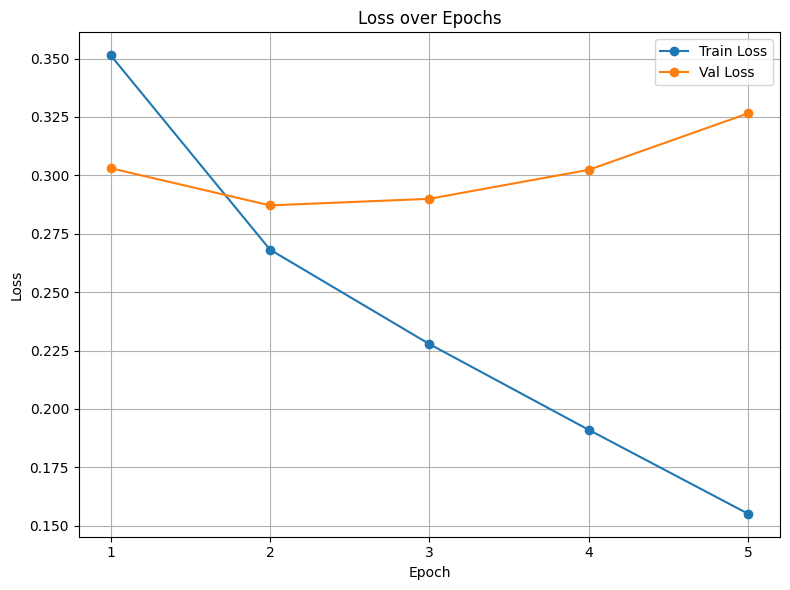

In [54]:
train_losses = torch.load('./results/base_model/train_losses.pth')
val_losses = torch.load('./results/base_model/val_losses.pth')

plot_loss(train_losses, val_losses, './results/base_model/loss_over_epochs.png')

### Performance Metrics

In [73]:
model = LSTMClassifier(len(stoi), 100, 128, 1).to(device)
model.load_state_dict(torch.load('./results/base_model/initial_model.pth'))

model.eval()
with torch.no_grad():
  test_pred_proba, test_labels, test_avg_loss, _, _ = evaluate(model, criterion, test_loader, device)

In [74]:
test_pred = (test_pred_proba >= 0).astype(int)

base_metrics = calculate_metrics(test_labels, test_pred_proba, test_pred, set = 'test')

print('Accuracy:', base_metrics['test_accuracy'])
print('Precision:', base_metrics['test_precision'])
print('Recall:', base_metrics['test_recall'])
print('Specificty:', base_metrics['test_specificity'])
print('F1 Score:', base_metrics['test_f1'])
print('AUROC:', base_metrics['test_auroc'])
print('AUPRC:', base_metrics['test_auprc'])

Accuracy: 0.8802297005742514
Precision: 0.8780073169761801
Recall: 0.88317
Specificty: 0.8772893864469322
F1 Score: 0.8805810915907233
AUROC: 0.9485579753023765
AUPRC: 0.945931270714558


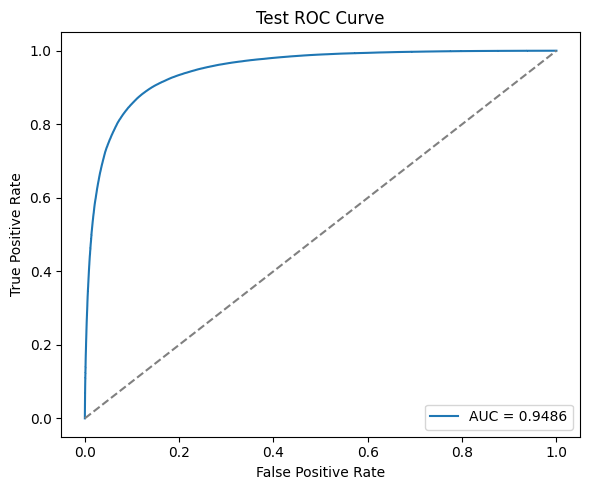

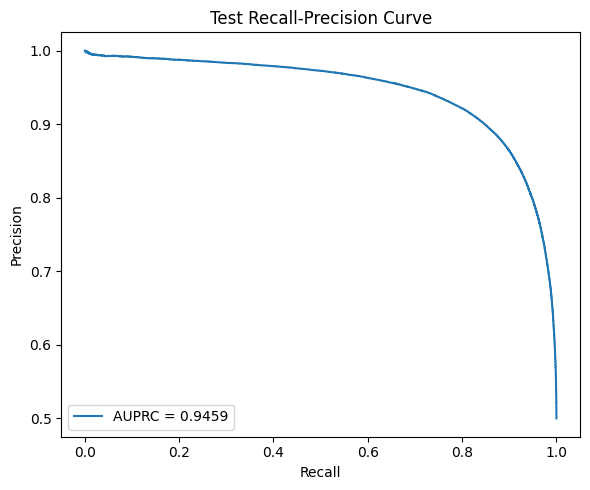

In [44]:
plot_roc_curve(test_labels, test_pred_proba, './results/base_model/roc_curve.png', set = 'Test')
plot_pr_curve(test_labels, test_pred_proba, './results/base_model/pr_curve.png', set = 'Test')

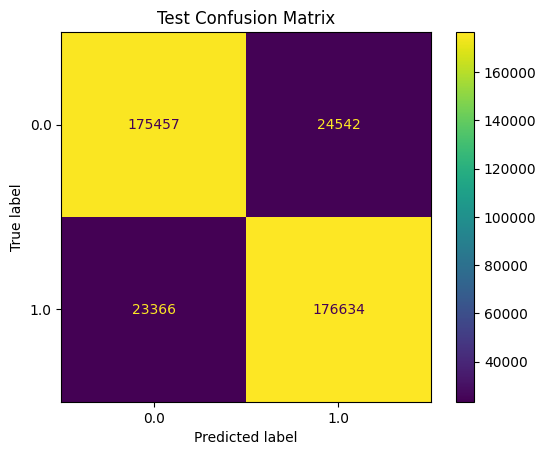

In [45]:
create_confusion_matrix(test_labels, test_pred, path = './results/base_model/confusion_matrix.png', set = 'Test')

## Attention Mechanism and Masking

This section introduces a custom attention mechanism for sequence modeling and a helper function to handle variable-length input sequences during attention computation.

This combination allows robust handling of padded sequences when using attention.

### Attention Module

The `Attention` class implements a simple attention mechanism that learns importance weights for each token in the LSTM output sequence. It computes a context vector as a weighted sum of LSTM outputs.

- **Inputs**:
  - `lstm_outputs`: Tensor of shape `(batch_size, seq_len, hidden_dim)` representing the output from the LSTM for each token.
  - `mask` (optional): A binary mask of shape `(batch_size, seq_len)` used to ignore padded positions when computing attention weights.
- **Outputs**:
  - `context`: A tensor of shape `(batch_size, hidden_dim)` representing the aggregated context vector.
  - `weights`: The attention weights over the sequence, useful for interpretability or visualization.

In [56]:
class Attention(nn.Module):
  """
  Applies an attention mechanism over LSTM outputs to produce a context vector.

  This module computes attention scores for each timestep in the LSTM output,
  applies a softmax to get weights, and uses these weights to calculate a weighted
  sum of the LSTM outputs.

  Args:
      hidden_dim (int): Dimensionality of the LSTM hidden state.
  """
  def __init__(self, hidden_dim):
    super(Attention, self).__init__()
    self.attn = nn.Linear(hidden_dim, 1)

  def forward(self, lstm_outputs, mask = None):
    """
    Compute the attention-weighted context vector from LSTM outputs.

    Args:
        lstm_outputs (Tensor): Tensor of shape (batch_size, seq_len, hidden_dim)
                                representing outputs from the LSTM.
        mask (Tensor, optional): Boolean mask of shape (batch_size, seq_len) indicating
                                  valid (non-padded) tokens.

    Returns:
        context (Tensor): Weighted sum of LSTM outputs. Shape (batch_size, hidden_dim).
        weights (Tensor): Attention weights for each token. Shape (batch_size, seq_len).
    """
    scores = self.attn(lstm_outputs).squeeze(-1)

    if mask is not None:
      scores = scores.masked_fill(~mask, float('-inf'))

    weights = F.softmax(scores, dim = 1)
    context = torch.bmm(weights.unsqueeze(1), lstm_outputs)

    return context.squeeze(1), weights

### Sequence Masking Utility

The `create_mask` function generates a binary mask for variable-length sequences to be used in attention. This ensures attention is only applied to real (non-padding) tokens.

- **Inputs**:
  - `lengths`: A tensor containing the length of each sequence in the batch.
  - `max_len` (optional): Maximum length to pad/truncate to. Defaults to the maximum in `lengths`.
- **Output**:
  - A boolean mask tensor of shape `(batch_size, max_len)`.

In [57]:
def create_mask(lengths, max_len=None):
    """
    Creates a boolean mask for padded sequences based on sequence lengths.

    This mask is used to identify the valid (non-padded) positions in each sequence,
    typically for attention mechanisms or loss calculations.

    Args:
        lengths (Tensor): A 1D tensor of shape (batch_size,) containing the lengths of each sequence.
        max_len (int, optional): The maximum sequence length to pad to. If None, uses the max value from `lengths`.

    Returns:
        Tensor: A boolean mask of shape (batch_size, max_len) where True indicates a valid token position.
    """
    batch_size = lengths.size(0)
    max_len = max_len or lengths.max()
    return torch.arange(max_len).expand(batch_size, max_len).to(lengths.device) < lengths.unsqueeze(1)

## LSTM Classifier with Attention

This model adds an attention mechanism on top of the LSTM to focus on important parts of the input sequence.

- **Embedding Layer**: Maps tokens to dense vectors.
- **LSTM Layer**: Encodes the sequence.
- **Attention Layer**: Learns weights over LSTM outputs to create a context vector.
- **Fully Connected Layer**: Produces the final prediction from the context vector.

The attention helps the model emphasize relevant tokens and improves handling of variable-length sequences.

In [58]:
class LSTMClassifierWithAttention(nn.Module):
  """
  An LSTM-based text classification model with an attention mechanism.

  This model embeds input tokens, processes them with an LSTM,
  and uses an attention mechanism to weight the LSTM outputs before
  making a prediction through a fully connected layer.

  Args:
      vocab_size (int): Size of the vocabulary.
      embed_dim (int): Dimensionality of the embedding vectors.
      hidden_dim (int): Number of hidden units in the LSTM.
      output_dim (int): Number of output classes (1 for binary classification).
  """
  def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
    super(LSTMClassifierWithAttention, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx = stoi['<PAD>'])
    self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first = True)
    self.attn = Attention(hidden_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x, lengths):
    """
    Forward pass of the model.

    Args:
        x (Tensor): Tensor of token indices of shape (batch_size, seq_len).
        lengths (Tensor): Lengths of each sequence in the batch (used for packing).

    Returns:
        Tensor: Output logits of shape (batch_size, output_dim).
    """
    embedded = self.embedding(x)
    packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first = True, enforce_sorted = False)
    out, (hidden, cell) = self.lstm(packed)

    out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first = True)
    mask = create_mask(lengths)

    context, weights = self.attn(out, mask)

    return self.fc(context)

## Attention Model Training with Early Stopping

This section defines the training loop for the `LSTMClassifierWithAttention`, including early stopping based on validation AUROC.

- The model is trained using the `BCEWithLogitsLoss` loss function and the Adam optimizer.
- Training and validation losses, AUROC, and AUPRC are tracked across epochs.
- Early stopping halts training if the validation AUROC does not improve for `patience` consecutive epochs.

The only difference from above is the attention mechanism.

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMClassifierWithAttention(len(stoi), 100, 128, 1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

train_dataset = CustomDataset(X_train_tokens, y_train.values, stoi)
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True, collate_fn = collate_fn)

val_dataset = CustomDataset(X_val_tokens, y_val.values, stoi)
val_loader = DataLoader(val_dataset, batch_size = 128, shuffle = False, collate_fn = collate_fn)

test_dataset = CustomDataset(X_test_tokens, y_test.values, stoi)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = False, collate_fn = collate_fn)

In [30]:
patience = 2
best_val_auc = 0.0
counter = 0

train_losses, train_aurocs, train_auprcs = [], [], []
val_losses, val_aurocs, val_auprcs = [], [], []
for i in range(10):
  print(f'Epoch {i + 1}')
  print('=================================')
  train_avg_loss, train_auroc, train_auprc = train(model, train_loader, criterion, optimizer, device)
  _, _, val_avg_loss, val_auroc, val_auprc = evaluate(model, criterion, val_loader, device)

  train_losses.append(train_avg_loss)
  train_aurocs.append(train_auroc)
  train_auprcs.append(train_auprc)

  val_losses.append(val_avg_loss)
  val_aurocs.append(val_auroc)
  val_auprcs.append(val_auprc)
  print('=================================')

  if val_auroc > best_val_auc:
      best_val_auc = val_auroc
      best_model_state = model.state_dict()
      counter = 0
  else:
      counter += 1
      if counter >= patience:
          print(f"Early stopping triggered at epoch {i + 1}")
          break

  print(f'Train Loss: {train_avg_loss:.4f}, Train AUROC: {train_auroc:.4f}, Train AUPRC: {train_auprc:.4f}')
  print(f'Val Loss: {val_avg_loss:.4f}, Val AUROC: {val_auroc:.4f}, Val AUPRC: {val_auprc:4f}')
  print()

Epoch 1
Batch 200 Average Loss: 0.4838
Batch 400 Average Loss: 0.4555
Batch 600 Average Loss: 0.4599
Batch 800 Average Loss: 0.3186
Batch 1000 Average Loss: 0.3407
Batch 1200 Average Loss: 0.2516
Batch 1400 Average Loss: 0.2732
Batch 1600 Average Loss: 0.3400
Batch 1800 Average Loss: 0.3768
Batch 2000 Average Loss: 0.2802
Batch 2200 Average Loss: 0.2610
Batch 2400 Average Loss: 0.2847
Batch 2600 Average Loss: 0.3476
Batch 2800 Average Loss: 0.2614
Batch 3000 Average Loss: 0.3197
Batch 3200 Average Loss: 0.2619
Batch 3400 Average Loss: 0.3370
Batch 3600 Average Loss: 0.2846
Batch 3800 Average Loss: 0.3041
Batch 4000 Average Loss: 0.2767
Batch 4200 Average Loss: 0.3568
Train Loss: 0.3402, Train AUROC: 0.9288, Train AUPRC: 0.9275
Val Loss: 0.2944, Val AUROC: 0.9472, Val AUPRC: 0.945507

Epoch 2
Batch 200 Average Loss: 0.2437
Batch 400 Average Loss: 0.2276
Batch 600 Average Loss: 0.2361
Batch 800 Average Loss: 0.3062
Batch 1000 Average Loss: 0.2296
Batch 1200 Average Loss: 0.2472
Batch 140

## Saving the Attention Model and Training Metrics

After training, the best model state and training metrics are saved for future analysis or fine-tuning. These files are saved to the `./results/attention_model/` directory.

In [31]:
torch.save(best_model_state, './results/attention_model/initial_model.pth')

torch.save(train_losses, './results/attention_model/train_losses.pth')
torch.save(train_aurocs, './results/attention_model/train_aurocs.pth')
torch.save(train_auprcs, './results/attention_model/train_auprcs.pth')

torch.save(val_losses, './results/attention_model/val_losses.pth')
torch.save(val_aurocs, './results/attention_model/val_aurocs.pth')
torch.save(val_auprcs, './results/attention_model/val_auprcs.pth')

## Evaluate Attention Model

### Loss Over Epochs

#### Again, we see some slight overfitting towards the end of training, but our early stopping prevents poor generalization.

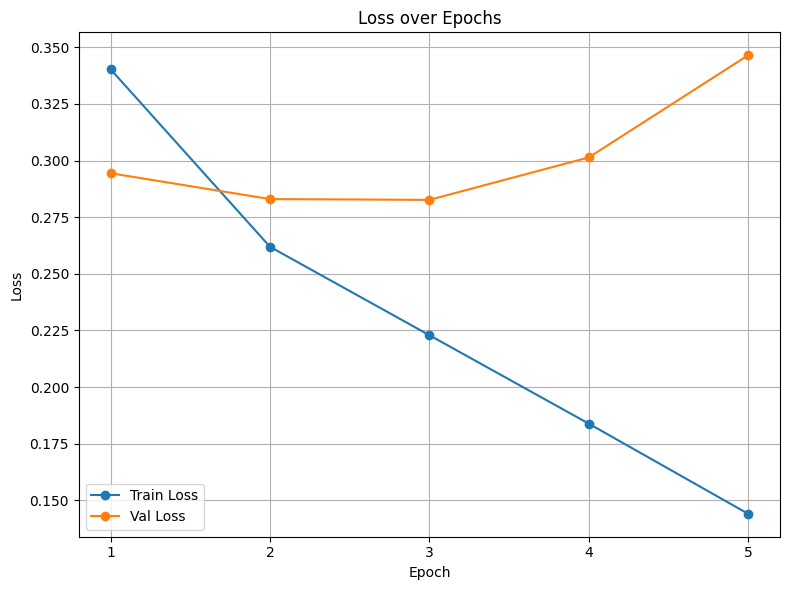

In [60]:
train_losses = torch.load('./results/attention_model/train_losses.pth')
val_losses = torch.load('./results/attention_model/val_losses.pth')

plot_loss(train_losses, val_losses, './results/attention_model/loss_over_epochs.png')

#### Performance Metrics

In [71]:
model = LSTMClassifierWithAttention(len(stoi), 100, 128, 1).to(device)
model.load_state_dict(torch.load('./results/attention_model/initial_model.pth'))

model.eval()
with torch.no_grad():
  test_pred_proba, test_labels, test_avg_loss, _, _ = evaluate(model, test_loader)

In [72]:
test_pred = (test_pred_proba >= 0).astype(int)

attention_metrics = calculate_metrics(test_labels, test_pred_proba, test_pred, set = 'test')

print('Accuracy:', attention_metrics['test_accuracy'])
print('Precision:', attention_metrics['test_precision'])
print('Recall:', attention_metrics['test_recall'])
print('Specificty:', attention_metrics['test_specificity'])
print('F1 Score:', attention_metrics['test_f1'])
print('AUROC:', attention_metrics['test_auroc'])
print('AUPRC:', attention_metrics['test_auprc'])

Accuracy: 0.8758546896367241
Precision: 0.8768234362311139
Recall: 0.87457
Specificty: 0.8771393856969285
F1 Score: 0.8756952684199196
AUROC: 0.9460111973309866
AUPRC: 0.9435957680311116


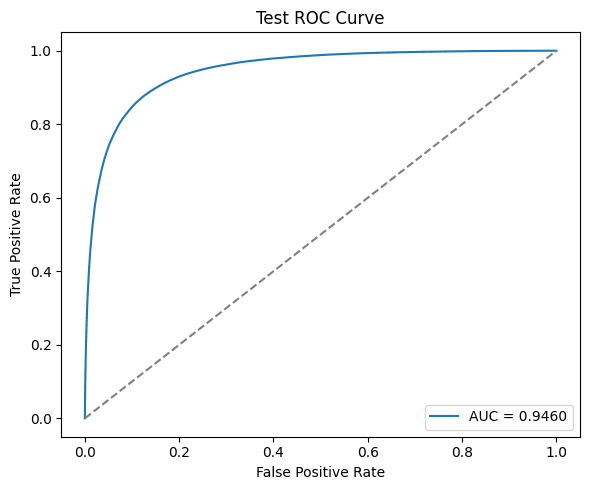

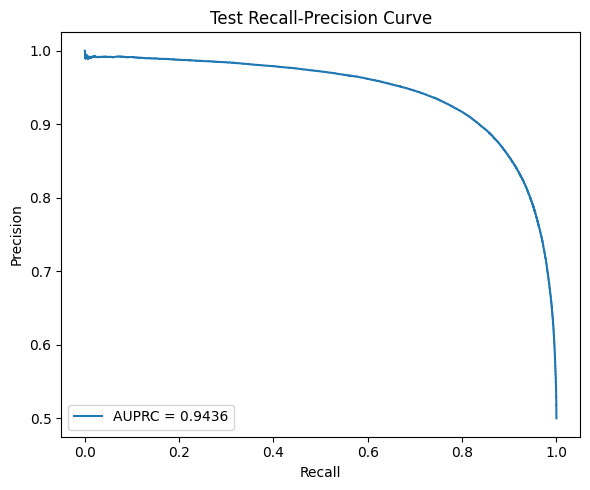

In [65]:
plot_roc_curve(test_labels, test_pred_proba, './results/attention_model/roc_curve.png', set = 'Test')
plot_pr_curve(test_labels, test_pred_proba, './results/attention_model/pr_curve.png', set = 'Test')

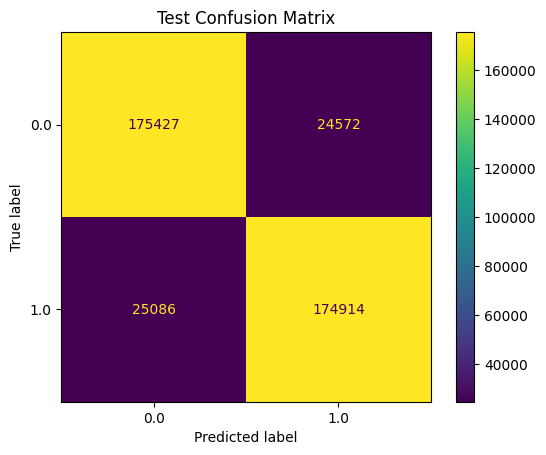

In [66]:
create_confusion_matrix(test_labels, test_pred, path = './results/attention_model/confusion_matrix.png', set = 'Test')

In [81]:
final_metrics = pd.DataFrame([base_metrics, attention_metrics]).T.reset_index()
final_metrics.columns = ['Metric', 'Base Model', 'Attention Model']
final_metrics['Metric'] = final_metrics['Metric'].str.replace('test_', '').str.title()

In [82]:
final_metrics

,Metric,Base Model,Attention Model
0,Accuracy,0.880230,0.875855
1,Precision,0.878007,0.876823
2,Recall,0.883170,0.874570
3,Specificity,0.877289,0.877139
4,F1,0.880581,0.875695
5,Auroc,0.948558,0.946011
6,Auprc,0.945931,0.943596


In [84]:
final_metrics.to_csv('./results/performance_metrics.csv', header = True, index = False)

### 📌 Conclusion

Both models performed strongly on binary sentiment classification for Amazon reviews. The base LSTM model slightly outperformed the attention-based model across most metrics, including accuracy, recall, and AUROC. While attention helped maintain competitive performance, it did not lead to significant gains—suggesting that for this task, the base LSTM was already effective at capturing relevant context. The slightly worse performance might be due to increased overfitting of the attention model due to its higher complexity.